In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import the some important Libraries
import numpy as np
import torch
from torch.utils.data import Dataset ,DataLoader,ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score
import cv2


In [ ]:
import sys
import random


In [ ]:


tumor=[]
healthy=[]
# Use a more specific glob pattern to ensure you're only selecting image files
for f in glob.iglob("/content/drive/MyDrive/Mri_project_code/data/brain_tumor_dataset/yes/*.jpg"): # or appropriate image extension
        img =cv2.imread(f)

        img =cv2.resize(img,(128,128))
        b, g, r=cv2.split(img)
        img=cv2.merge([r,g,b])
        tumor.append(img)

for f in glob.iglob("/content/drive/MyDrive/Mri_project_code/data/brain_tumor_dataset/no/*.jpg"): # or appropriate image extension
        img =cv2.imread(f)

        img =cv2.resize(img,(128,128))
        b, g, r=cv2.split(img)
        img=cv2.merge([r,g,b])
        healthy.append(img)


In [ ]:
healthy=np.array(healthy)
tumor=np.array(tumor)
All = np.concatenate((healthy,tumor))

In [ ]:
tumor.shape

(86, 128, 128, 3)

In [ ]:
All.shape

(171, 128, 128, 3)

In [ ]:
healthy.shape

(85, 128, 128, 3)

In [ ]:
np.random.choice(10,5,replace=False)

array([0, 2, 1, 9, 5])

In [ ]:
healthy[0].shape

(128, 128, 3)

In [ ]:
# Visualization Brain Mri

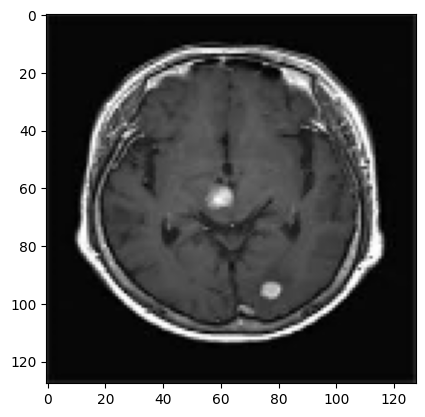

In [ ]:

plt.imshow(healthy[5])

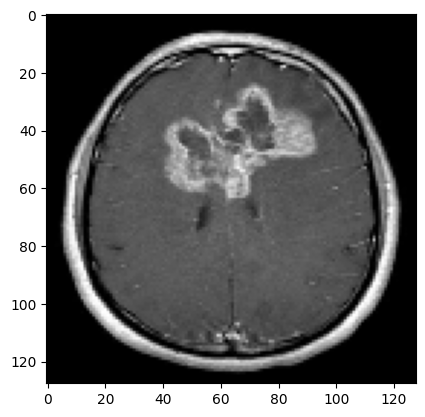

In [ ]:
plt.imshow(tumor[9])

In [ ]:
def plot_random(healthy,tumor,num=5):
  healthy_imgs=healthy[np.random.choice(healthy.shape[0],num,replace=False)]
  tumor_imgs=tumor[np.random.choice(tumor.shape[0],num,replace=False)]

  plt.figure(figsize=(16,9))
  for i in range(num):
    plt.subplot(1,num,i+1)
    plt.title("Healthy")
    plt.imshow(healthy_imgs[i])

  plt.figure(figsize=(16,9))
  for i in range(num):
    plt.subplot(1,num,i+1)
    plt.title("Tumor")
    plt.imshow(tumor_imgs[i])





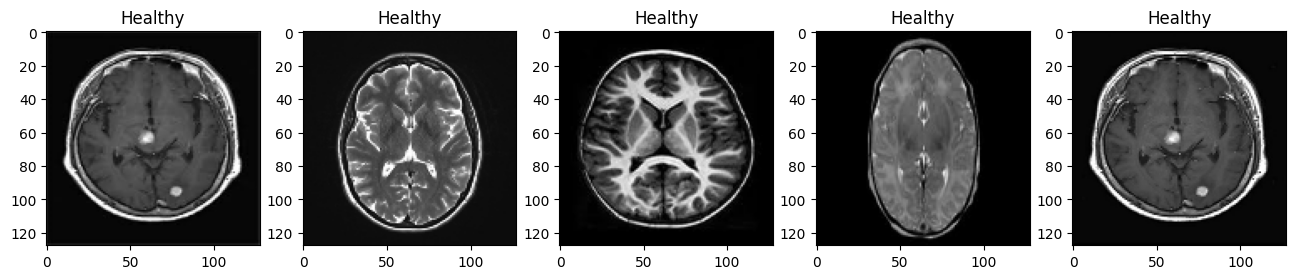

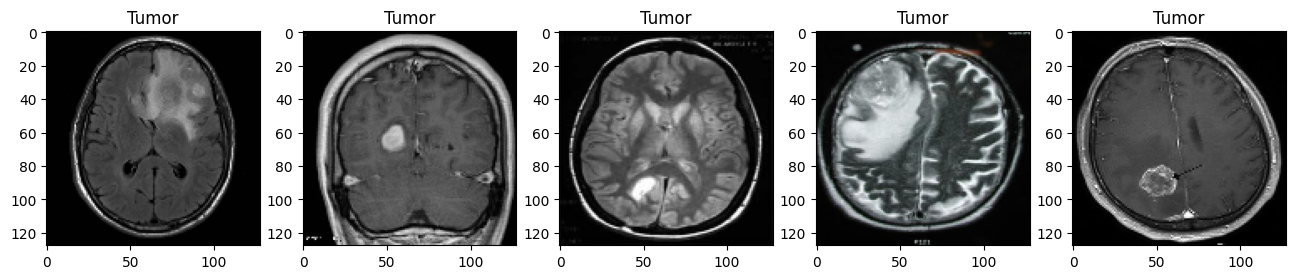

In [ ]:
plot_random(healthy,tumor)

In [ ]:
## Create torch Dataset Class
##     What is Pytorch's Abstract Dataset Class
##      """An abstract class representing a Dataset.

      # All other datasets should subclass it. All subclasses should override
      # ``__len__``, that provides the size of the dataset, and ``__getitem__``,
      # supporting integer indexing in range from 0 to len(self) exclusive.
      # """


In [ ]:
class Dataset(object):
  def __getitem__(self,index):
    raise NotImplementedError

  def __len__(self):
    raise NotImplementedError

  def __add__(self,other):
    return ConcatDataset([self,other])



In [ ]:
mri_dataset = MRI()


In [ ]:
mri_dataset.normalize()

In [ ]:
####    Creating a dataloader


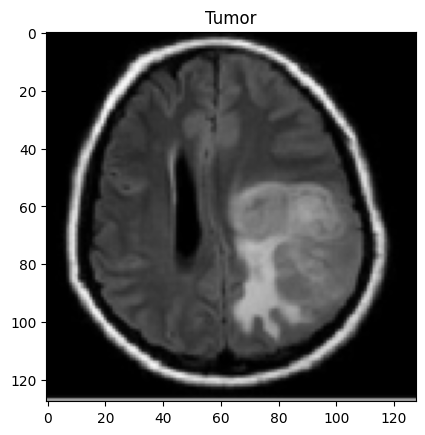

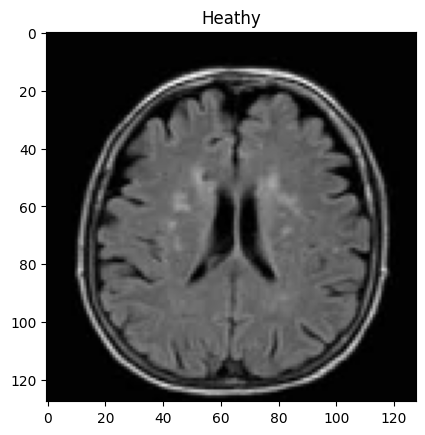

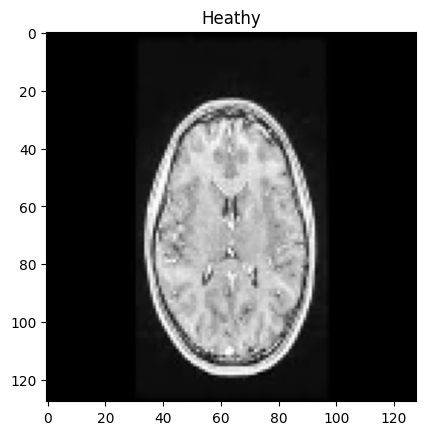

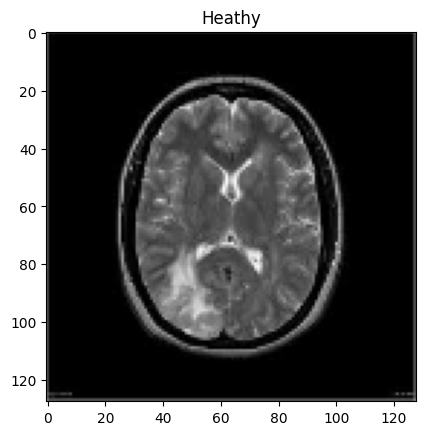

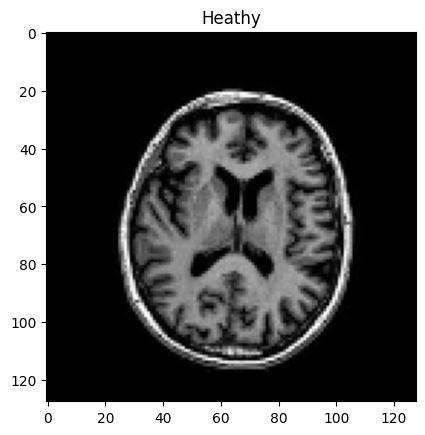

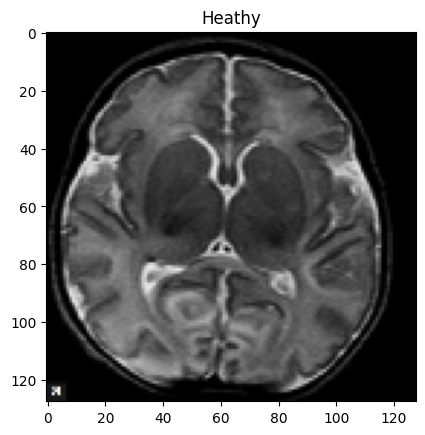

In [ ]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

In [ ]:
## Create a model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x


In [ ]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.2441, 0.2150, 0.6053, 0.5623, 0.9585, 0.8976, 0.9489, 0.5987, 0.2458,
        0.2762], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.2441, 0.2150, 0.6053, 0.5623, 0.9585, 0.8976, 0.9489, 0.5987, 0.2458,
        0.2762], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.0596, 0.0462, 0.3664, 0.3161, 0.9188, 0.8057, 0.9004, 0.3585, 0.0604,
        0.0763], device='cuda:0')


In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0')
model = CNN().to(device)

In [ ]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)


In [ ]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())


In [ ]:

outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [ ]:

def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [ ]:
accuracy_score(y_true, threshold(outputs))


0.5087719298245614

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

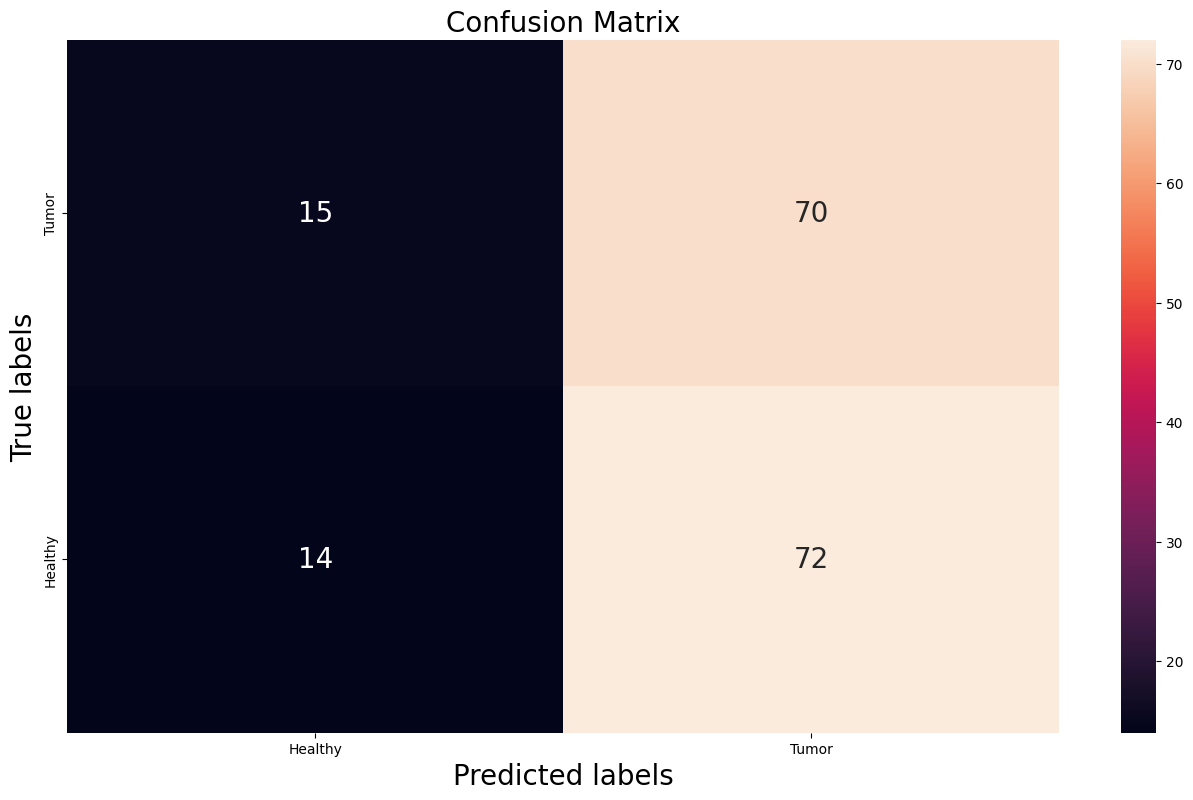

In [ ]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=10)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=10)

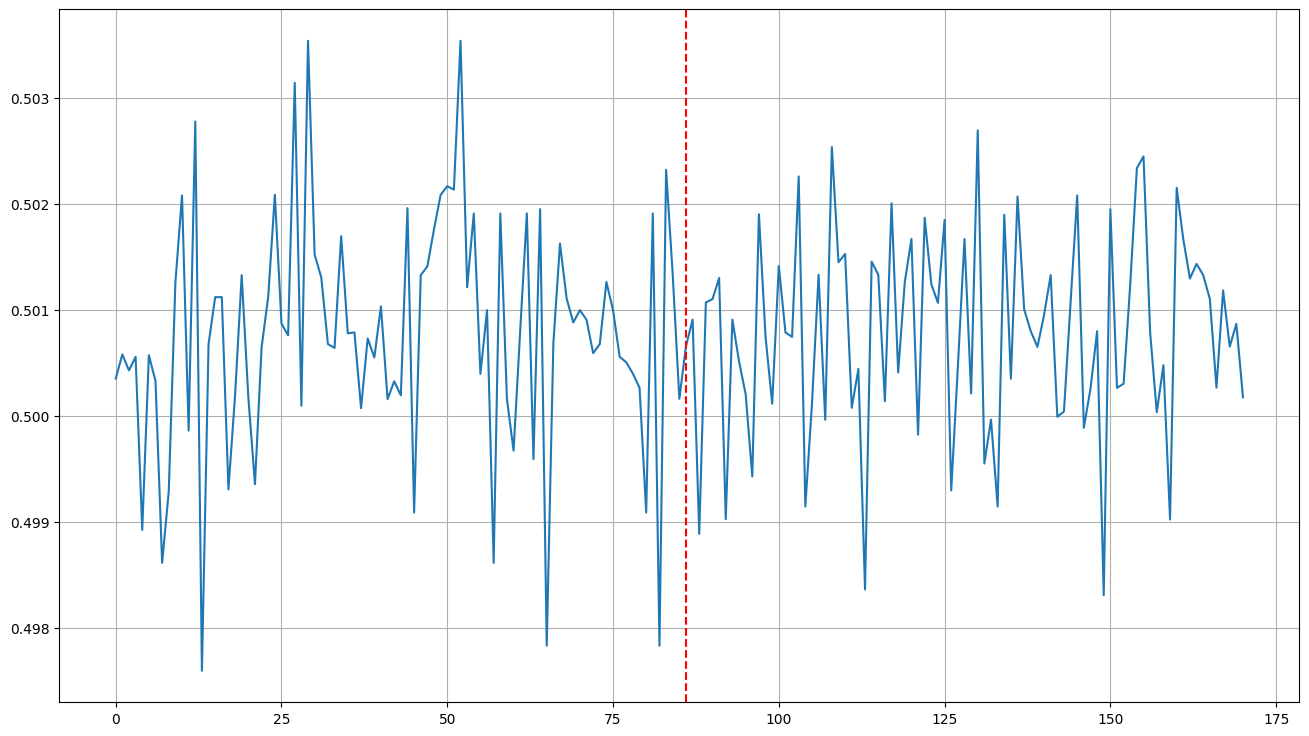

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [ ]:
# Train the dumb model
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()


CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [ ]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.659076
Train Epoch: 20	Loss: 0.589985
Train Epoch: 30	Loss: 0.551779
Train Epoch: 40	Loss: 0.548469
Train Epoch: 50	Loss: 0.535702
Train Epoch: 60	Loss: 0.510296
Train Epoch: 70	Loss: 0.477935
Train Epoch: 80	Loss: 0.441032
Train Epoch: 90	Loss: 0.418646
Train Epoch: 100	Loss: 0.378669
Train Epoch: 110	Loss: 0.409234
Train Epoch: 120	Loss: 0.333010
Train Epoch: 130	Loss: 0.324855
Train Epoch: 140	Loss: 0.323039
Train Epoch: 150	Loss: 0.294342
Train Epoch: 160	Loss: 0.288495
Train Epoch: 170	Loss: 0.252965
Train Epoch: 180	Loss: 0.221620
Train Epoch: 190	Loss: 0.200062
Train Epoch: 200	Loss: 0.183182
Train Epoch: 210	Loss: 0.170293
Train Epoch: 220	Loss: 0.144825
Train Epoch: 230	Loss: 0.140071
Train Epoch: 240	Loss: 0.125080
Train Epoch: 250	Loss: 0.095799
Train Epoch: 260	Loss: 0.083845
Train Epoch: 270	Loss: 0.070492
Train Epoch: 280	Loss: 0.050600
Train Epoch: 290	Loss: 0.045282
Train Epoch: 300	Loss: 0.033287
Train Epoch: 310	Loss: 0.027180
Train Epoch: 320	

In [ ]:
#Evaluate a smart model


In [ ]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [ ]:
accuracy_score(y_true, threshold(outputs))

1.0

In [ ]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

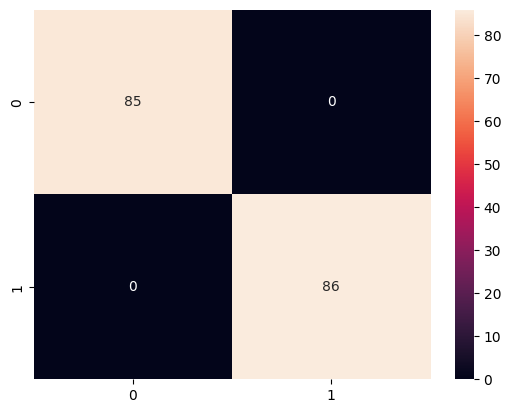

In [ ]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation


In [ ]:

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

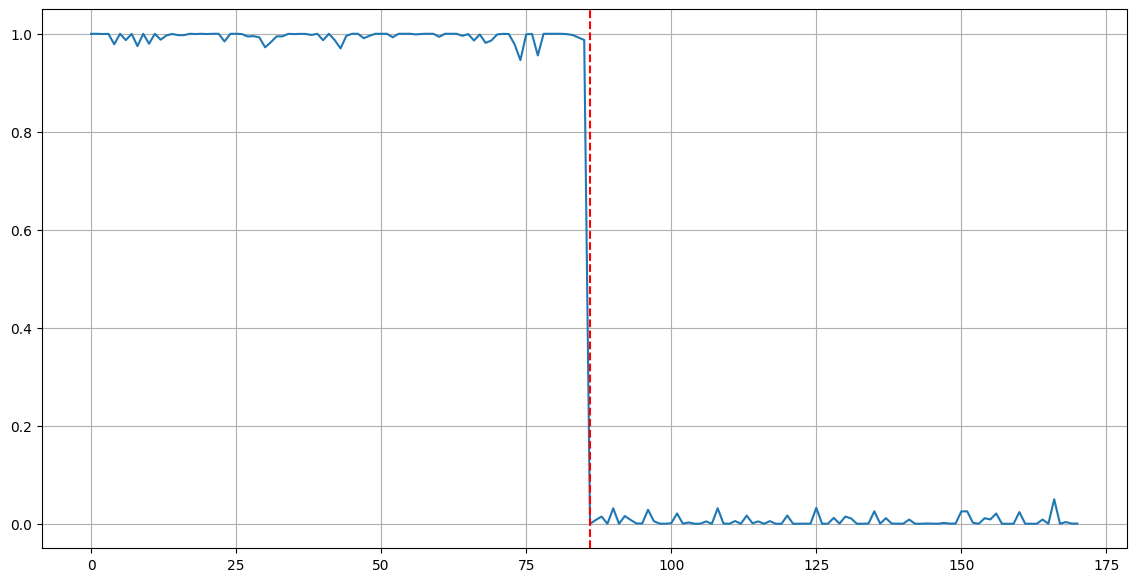

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [ ]:
# Visualising the Feature Maps of the Convolutional Filters

In [ ]:
model


CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [ ]:
no_of_layers = 0
conv_layers = []

In [ ]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [ ]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [ ]:
conv_layers


[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

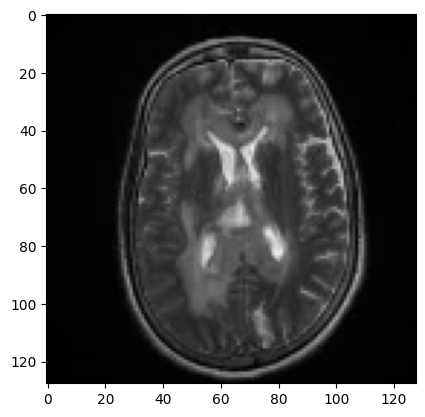

In [ ]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))


In [ ]:
img = torch.from_numpy(img).to(device)


In [ ]:
img.shape


torch.Size([3, 128, 128])

In [ ]:
img = img.unsqueeze(0)
img.shape


torch.Size([1, 3, 128, 128])

In [ ]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# # Are We Over-fitting?
# Preparing a validation set: We need to change the MRI dataset slightly!
# We will need to make changes to our MRI dataset class:

# Define a function to divide the data into train and validation sets
# Define a variable called mode to determine whether we are interested in the training OR validation data
# Change len() and getitem() functions and conditioned over the variable mode

In [ ]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split


In [ ]:
class MRI(Dataset):

    def __init__(self):

        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None

        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'

        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("/content/drive/MyDrive/Mri_project_code/data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("/content/drive/MyDrive/Mri_project_code/data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]

    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}

        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}

        return sample


    def normalize(self):
        self.images = self.images/255.0




In [ ]:
#Are we overfitting?


In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()


In [ ]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)


In [ ]:
device = torch.device("cuda:0")
model = CNN().to(device)


In [ ]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)


In [ ]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []


In [ ]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    # validate for the current epoch
    val_losses = []
    model.eval()

    mri_dataset.mode = 'val'

    with torch.no_grad():
      for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())

    epoch_val_loss.append(np.mean(val_losses))

    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))


Train Epoch: 10	Train Loss: 0.669945	Val Loss: 0.684512
Train Epoch: 20	Train Loss: 0.649130	Val Loss: 0.656951
Train Epoch: 30	Train Loss: 0.601085	Val Loss: 0.612809
Train Epoch: 40	Train Loss: 0.567700	Val Loss: 0.555711
Train Epoch: 50	Train Loss: 0.532527	Val Loss: 0.526313
Train Epoch: 60	Train Loss: 0.494694	Val Loss: 0.517729
Train Epoch: 70	Train Loss: 0.438723	Val Loss: 0.519202
Train Epoch: 80	Train Loss: 0.422336	Val Loss: 0.526300
Train Epoch: 90	Train Loss: 0.422726	Val Loss: 0.537385
Train Epoch: 100	Train Loss: 0.381941	Val Loss: 0.548957
Train Epoch: 110	Train Loss: 0.409933	Val Loss: 0.549416
Train Epoch: 120	Train Loss: 0.334583	Val Loss: 0.581929
Train Epoch: 130	Train Loss: 0.307368	Val Loss: 0.571950
Train Epoch: 140	Train Loss: 0.269617	Val Loss: 0.570048
Train Epoch: 150	Train Loss: 0.284295	Val Loss: 0.563083
Train Epoch: 160	Train Loss: 0.240963	Val Loss: 0.561736
Train Epoch: 170	Train Loss: 0.216408	Val Loss: 0.558893
Train Epoch: 180	Train Loss: 0.215666	Va

Text(0, 0.5, 'Loss')

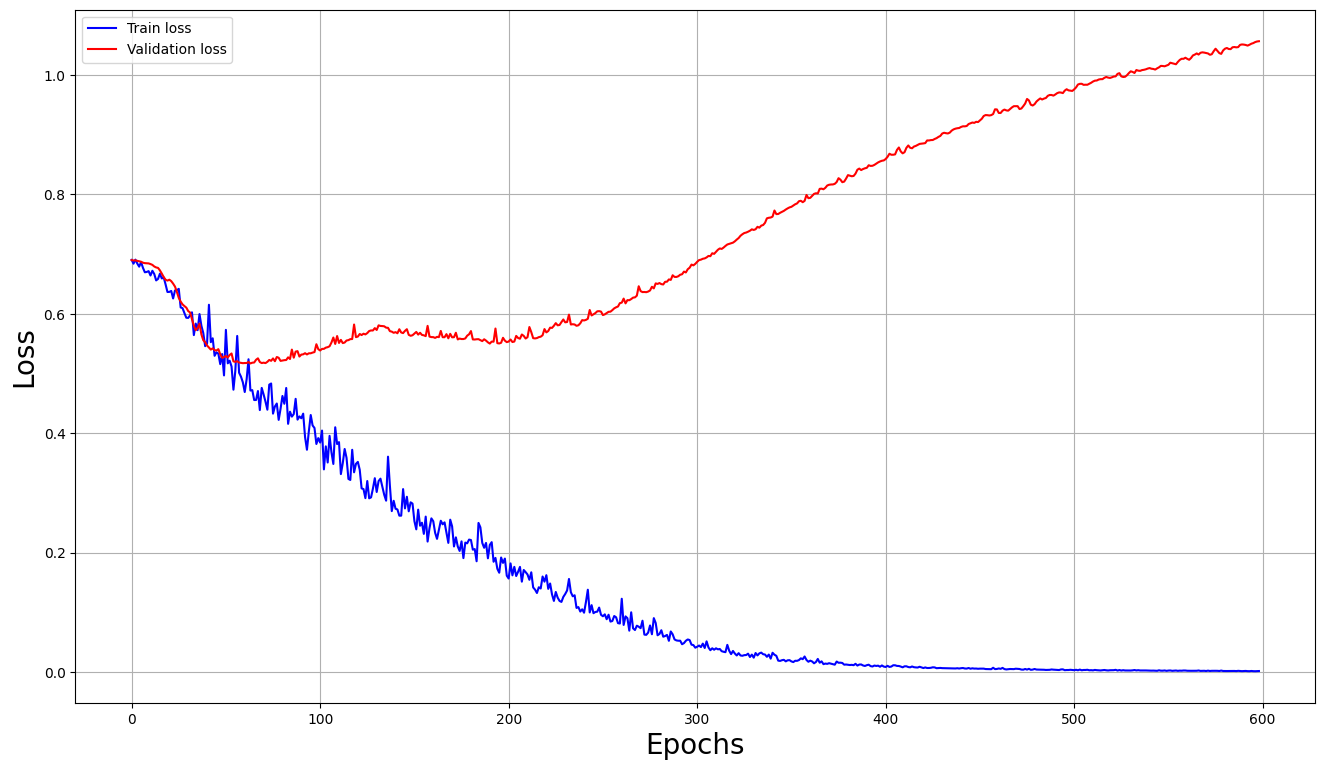

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
